In [1]:
# !pip install -q roboflow supervision==0.25.1 
# !pip install -q peft bitsandbytes transformers==4.47.0 # if using higher version of transformers then you will get No labels error for peft, use eager attention in from_pretrained

In [1]:
import os
id = 2
os.environ['CUDA_VISIBLE_DEVICES'] = f'{id}'

In [2]:
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from glob import glob
import torch 
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
import matplotlib.pyplot as plt
import random
import supervision as sv
import json

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# planet imagery
# all_images = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train/images/*'))
# train_labels = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train/labels/*'))
# non_bg_images = sorted([os.path.basename(train_label)[:-4]+'.tif' for train_label in train_labels])
# bg_images = sorted([os.path.basename(image_name) for image_name in all_images if os.path.basename(image_name) not in non_bg_images])

# gms imagery
all_images = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/train/images/*'))
train_labels = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/train/labels/*'))
non_bg_images = sorted([os.path.basename(train_label)[:-4]+'.png' for train_label in train_labels])

In [5]:
print(len(non_bg_images))
# print(len(bg_images))

98


In [6]:
num_non_bg_image = 1
num_bg_image = 0

In [7]:
import shutil

dynamic_dir = '../dynamic_train/images'
# source_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train/images'
source_path = "/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/train/images"

if os.path.exists(dynamic_dir):
    shutil.rmtree(dynamic_dir)

if not os.path.exists(dynamic_dir):
    os.makedirs(dynamic_dir)

# creating symlink to non background images
for image_name in sorted(non_bg_images)[:num_non_bg_image]:
    source = os.path.join(source_path, image_name) 
    destination = os.path.join(dynamic_dir, image_name)
    os.symlink(src = source, dst = destination)

# creating symlink to background images
# for image_name in sorted(bg_images)[:num_bg_image]:
#     source = os.path.join(source_path, image_name) 
#     destination = os.path.join(dynamic_dir, image_name)
#     os.symlink(src = source, dst = destination)

dynamic_dir = '../dynamic_train/labels'
# source_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train/labels'
source_path = "/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/train/labels"

if os.path.exists(dynamic_dir):
    shutil.rmtree(dynamic_dir)

if not os.path.exists(dynamic_dir):
    os.makedirs(dynamic_dir)

# creating symlink to non background labels
for image_name in sorted(non_bg_images)[:num_non_bg_image]:
    source = os.path.join(source_path, image_name[:-4]+'.txt') 
    destination = os.path.join(dynamic_dir, image_name[:-4]+'.txt')
    os.symlink(src = source, dst = destination)


In [8]:
# class TifPatchDataset(Dataset):
#     def __init__(self, labels_file_path: str, image_directory_path: str, prompt: str, start : int, end : int, type : str):
#         self.prompt = prompt
#         self.start = start
#         self.end = end
#         self.type = type
#         self.non_bg_img = []
#         self.non_bg_img_name = []
#         self.labels_file_path = labels_file_path
#         self.image_directory_path = image_directory_path
#         self.entries = self._load_entries()
        
                
#     def _convert_to_paligemma_format(self, pil_image, absolute_bbox):

#         image_width, image_height = pil_image.size
#         tmp = []

#         if len(absolute_bbox) == 0:
#             tmp.append(f'<loc0000><loc0000><loc1024><loc1024> background')

#         for bbox in absolute_bbox:
#             xmin = min(bbox[[1,3,5,7]])
#             ymin = min(bbox[[2,4,6,8]])
#             xmax = max(bbox[[1,3,5,7]])
#             ymax = max(bbox[[2,4,6,8]])
            
#             xmin = (xmin)/image_width * 1024
#             ymin = (ymin)/image_width * 1024
#             xmax = (xmax)/image_width * 1024
#             ymax = (ymax)/image_width * 1024

#             ymin, xmin, ymax, xmax = ['0'*(4-len(x))+str(x) if len(x) < 4 else x for x in [str(int(ymin)), str(int(xmin)), str(int(ymax)), str(int(xmax))] ]
#             tmp.append(f'<loc{ymin}><loc{xmin}><loc{ymax}><loc{xmax}> {self.prompt}')
        
#         tmp = ' ; '.join(tmp)
#         # create a dictionary with PIL image in one key and its bbox in another key suffix, make sure to bring the bbox range in (0, 1024)
#         paligemma_labels = {'image': pil_image, 'suffix': tmp, 'prefix': f'detect {self.prompt} ; background' }
        
#         return paligemma_labels

#     def _load_entries(self): # load the bbox of all patches
#         entries = []
#         for idx, image_path in enumerate(sorted(glob(self.image_directory_path+'/*'))[self.start:self.end]):
#             img_name = os.path.basename(image_path)
#             img = Image.open(image_path)
#             w, h = img.size
#             label_path = os.path.join(self.labels_file_path,img_name[:-4]+'.txt')
#             if os.path.exists(label_path):
#                 bbox = np.loadtxt(label_path, ndmin = 2)
#                 bbox = bbox*w
#                 self.non_bg_img.append(idx)
#                 self.non_bg_img_name.append(image_path)
#             else:
#                 bbox = []
#             entries.append(self._convert_to_paligemma_format(img, bbox))

#         return entries

#     def __len__(self):
#         return len(self.entries)

#     def __getitem__(self, idx: int):
#         if idx < 0 or idx >= len(self.entries):
#             raise IndexError("Index out of range")

#         entry = self.entries[idx]
#         image = self.entries[idx]['image']
#         return image, entry

In [9]:
# train_dataset = TifPatchDataset(
#     labels_file_path=f"../dynamic_train/labels", 
#     image_directory_path=f"../dynamic_train/images", 
#     prompt = 'brick kilns with chimney',
#     start = 0,
#     end = num_non_bg_image+num_bg_image,
#     type = 'train'
# ) 

# test_dataset = TifPatchDataset(
#     # labels_file_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/labels", 
#     # image_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/images", # planet images
#     labels_file_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/labels", 
#     image_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/images", 
#     prompt = 'brick kilns with chimney',
#     start = 0,
#     end = 649,
#     type = 'test'
# ) 


In [4]:
class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry

In [5]:
train_dataset = JSONLDataset(
    jsonl_file_path=f'/home/shataxi.dubey/shataxi_work/vlm_on_planet/dynamic_train/paligemma2_annotations.jsonl',
    image_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/dynamic_train/images",
)
valid_dataset = JSONLDataset(
    jsonl_file_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/valid/paligemma2_annotations.jsonl",
    image_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/valid/images",
)
# test_dataset = JSONLDataset(
#     jsonl_file_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/paligemma2_annotations.jsonl",
#     image_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/images",
# )


test_dataset = JSONLDataset(
    jsonl_file_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/test/paligemma2_annotations.jsonl",
    image_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/test/images",
)


In [6]:
len(train_dataset),len(test_dataset)

(1, 27)

In [7]:
# train_dataset.non_bg_img[:5], train_dataset.non_bg_img_name[:5]

In [8]:
import re
def parse_bbox_and_labels(detokenized_output: str):
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      ' (?P<label>(\w+\s?)+\w)',
      detokenized_output,
  )
  labels, boxes = [], []
  fmt = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    # print(d)
    boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
    labels.append(d['label'])
  return np.array(boxes), np.array(labels)

In [9]:
sum = 0
for i in range(len(train_dataset)):
    box, label = parse_bbox_and_labels(train_dataset.entries[i]['suffix'])
    for classname in label:
        if 'brick kilns with chimney' in classname:
            sum += 1
print(f'Total number of kilns in the train set {sum}')

Total number of kilns in the train set 1


In [10]:
sum = 0
for i in range(len(test_dataset)):
    box, label = parse_bbox_and_labels(test_dataset.entries[i]['suffix'])
    for classname in label:
        if 'brick kilns with chimney' in classname:
            sum += 1
print(f'Total number of kilns in the test set {sum}')

Total number of kilns in the test set 31


In [11]:
CLASSES = test_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")
CLASSES

['brick kilns with chimney']

In [12]:
# images = []
# for i in [0,2,3,4]:
#     image, label = train_dataset[i]
#     detections = sv.Detections.from_lmm(
#         lmm='paligemma',
#         result=label["suffix"],
#         resolution_wh=(image.width, image.height),
#         classes=CLASSES)
#     # print(detections)
#     image = sv.BoxAnnotator(thickness=4).annotate(image, detections)
#     image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
#     images.append(image)

# sv.plot_images_grid(images, (2,2))

In [7]:
MODEL_ID ="google/paligemma2-3b-pt-448"
# MODEL_ID = 'google/paligemma2-10b-pt-448' # on single GPU, it can not be loaded
# MODEL_ID = 'google/paligemma2-3b-mix-448'
# MODEL_ID = 'google/paligemma-3b-ft-rsvqa-lr-448'
# MODEL_ID = 'google/paligemma-3b-ft-rsvqa-hr-448'


In [8]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)

In [9]:
# @title Fine-tune the entire model with LoRA and QLoRA

from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto", quantization_config= bnb_config, torch_dtype= torch.bfloat16)
model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto")
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

TORCH_DTYPE = model.dtype

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Fine-tune PaliGemma2 on custom object detection dataset

In [20]:
from math import ceil
from transformers import Trainer, TrainingArguments


def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)


def collate_fn(batch):
    images, labels = zip(*batch)

    paths = [label["image"] for label in labels]
    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

num_train_epochs = 50
batch = 4
gradient_update_steps =8
steps = ceil(len(train_dataset) / (batch * gradient_update_steps)) * num_train_epochs
# Note: trainer uses max_steps, it calculates the num_train_epochs automatically when max_steps is provided explicitly. num_train_epochs = (max_steps // updates_per_epoch) 
# Refer: https://github.com/huggingface/transformers/blob/772307be7649e1333a933cfaa229dc0dec2fd331/src/transformers/trainer.py#L1585
args = TrainingArguments(
    # num_train_epochs=100,
    max_steps = steps,
    remove_unused_columns=False,
    per_device_train_batch_size= batch,
    gradient_accumulation_steps= gradient_update_steps,
    seed = 2,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=1, # weights and biases logging step
    logging_strategy = 'epoch',
    optim="adamw_hf",
    save_strategy="steps", # checkpoint is saved after steps
    save_steps=1000,  # checkpoint is saved after every 1000 steps
    save_total_limit=1,
    output_dir=f"paligemma2_object_detection_{num_non_bg_image}_{num_bg_image}_r_8_alpha_8_gms", # model predictions and checkpoint will be present
    bf16=True,
    # report_to="none", # disconnects wandb
    dataloader_pin_memory=False,
    # disable_tqdm = True # enable logs to appear in output cell
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [21]:
steps

100

In [22]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shataxi-dubey (shataxi). Use `wandb login --relogin` to force relogin


It is strongly recommended to train Gemma2 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss
2,11.840000
4,11.841500
6,11.789900
8,11.707300
10,11.567200
12,11.392900
14,11.208900
16,11.040200
18,10.872600
20,10.714000


TrainOutput(global_step=100, training_loss=9.55366304397583, metrics={'train_runtime': 486.7301, 'train_samples_per_second': 6.574, 'train_steps_per_second': 0.205, 'total_flos': 3.0649782192768e+16, 'train_loss': 9.55366304397583, 'epoch': 50.0})

In [23]:
trainer.state

TrainerState(epoch=50.0, global_step=100, max_steps=100, logging_steps=1, eval_steps=500, save_steps=1000, train_batch_size=4, num_train_epochs=100, num_input_tokens_seen=0, total_flos=3.0649782192768e+16, log_history=[{'loss': 11.84, 'grad_norm': 2.598628044128418, 'learning_rate': 2e-05, 'epoch': 1.0, 'step': 2}, {'loss': 11.8415, 'grad_norm': 2.9354026317596436, 'learning_rate': 1.9591836734693877e-05, 'epoch': 2.0, 'step': 4}, {'loss': 11.7899, 'grad_norm': 3.8660290241241455, 'learning_rate': 1.9183673469387756e-05, 'epoch': 3.0, 'step': 6}, {'loss': 11.7073, 'grad_norm': 2.6384358406066895, 'learning_rate': 1.8775510204081636e-05, 'epoch': 4.0, 'step': 8}, {'loss': 11.5672, 'grad_norm': 3.2672371864318848, 'learning_rate': 1.836734693877551e-05, 'epoch': 5.0, 'step': 10}, {'loss': 11.3929, 'grad_norm': 3.422988176345825, 'learning_rate': 1.795918367346939e-05, 'epoch': 6.0, 'step': 12}, {'loss': 11.2089, 'grad_norm': 2.9529740810394287, 'learning_rate': 1.7551020408163266e-05, 'e

### Run inference with fine-tuned PaliGemma2 model

In [24]:
# model.save_pretrained('my_pretrained')

In [25]:
# processor.save_pretrained('my_pretrained_processor')

In [26]:
model = PaliGemmaForConditionalGeneration.from_pretrained(f'paligemma2_object_detection_{num_non_bg_image}_{num_bg_image}_r_8_alpha_8_gms/checkpoint-{steps}', device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
TORCH_DTYPE = model.dtype
TORCH_DTYPE

torch.float32

Suffix <loc0262><loc0248><loc0511><loc0619> brick kilns with chimney


Predicted <loc0295><loc0300><loc0469><loc0604> brick kilns with chimney


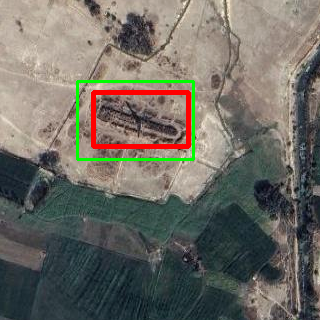

In [24]:
image, label = train_dataset[0]
prefix = "<image>" + label["prefix"]
suffix = label["suffix"]
print(f'Suffix {suffix}')
inputs = processor(
    text=prefix,
    images=image,
    return_tensors="pt"
).to(TORCH_DTYPE).to(DEVICE)

prefix_length = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    generation = generation[0][prefix_length:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(f'Predicted {decoded}')

w, h = image.size
detections = sv.Detections.from_vlm(
    vlm='paligemma',
    result=decoded,
    resolution_wh=(w, h),
    classes=CLASSES)

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator(thickness = 4, color = sv.Color(r=255, g= 0, b= 0)).annotate(annotated_image, detections)
# annotated_image = sv.LabelAnnotator(smart_position=True).annotate(annotated_image, detections)
detections = sv.Detections.from_vlm(
    vlm='paligemma',
    result=suffix,
    resolution_wh=(w, h),
    classes=CLASSES)
annotated_image = sv.BoxAnnotator(thickness = 2, color = sv.Color(r=0, g= 255, b= 0)).annotate(annotated_image, detections)
annotated_image

## Evaluate finetuned PaliGemma2 Model

In [12]:
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

def collate_test_fn(batch):
    images, labels = zip(*batch)

    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [label["suffix"] for label in labels]
    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return images, inputs, suffixes

test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn= collate_test_fn, shuffle=False)

images = []
targets = []
predictions = []

with torch.inference_mode():
    for imgs, test_inputs, suffixes in tqdm(test_dataloader):
        # print(test_inputs['input_ids'])
        prefix_length = test_inputs["input_ids"].shape[-1]

        generation = model.generate(**test_inputs, max_new_tokens=256, do_sample=False)
        generation = generation[:, prefix_length:]
        generated_texts = processor.batch_decode(generation, skip_special_tokens=True)
        w, h = imgs[0].size
        for generated_text in generated_texts:
            prediction = sv.Detections.from_vlm(
                vlm='paligemma',
                result=generated_text,
                resolution_wh=(w, h),
                # classes=CLASSES
                )
            
            prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
            prediction.confidence = np.ones(len(prediction))
            predictions.append(prediction)

        for suffix in suffixes:
            target = sv.Detections.from_vlm(
                vlm='paligemma',
                result=suffix,
                resolution_wh=(w, h),
                # classes=CLASSES
                )

            target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])
            targets.append(target)
        images += list(imgs)

# with torch.inference_mode():
#     for i in tqdm(range(len(train_dataset))):
#         image, label = train_dataset[i]
#         prefix = "<image>" + label["prefix"]
#         suffix = label["suffix"]

#         inputs = processor(
#             text=prefix,
#             images=image,
#             return_tensors="pt"
#         ).to(TORCH_DTYPE).to(DEVICE)

#         prefix_length = inputs["input_ids"].shape[-1]

#         generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
#         generation = generation[0][prefix_length:]
#         generated_text = processor.decode(generation, skip_special_tokens=True)

#         w, h = image.size
#         prediction = sv.Detections.from_lmm(
#             lmm='paligemma',
#             result=generated_text,
#             resolution_wh=(w, h),
#             classes=CLASSES)

#         prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
#         prediction.confidence = np.ones(len(prediction))

#         target = sv.Detections.from_lmm(
#             lmm='paligemma',
#             result=suffix,
#             resolution_wh=(w, h),
#             classes=CLASSES)

#         target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

#         images.append(image)
#         targets.append(target)
#         predictions.append(prediction)

100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


In [13]:
# @title Calculate mAP

from supervision.metrics import MeanAveragePrecision, MetricTarget

map_metric = MeanAveragePrecision(metric_target=MetricTarget.BOXES)
map_result = map_metric.update(predictions, targets).compute()
print(f'mAP@50 {map_result.map50}, mAP@50:95 {map_result.map50_95} \n')
print(map_result)

mAP@50 0.08056190234408056, mAP@50:95 0.02770584750782771 

MeanAveragePrecisionResult:
Metric target: MetricTarget.BOXES
Class agnostic: False
mAP @ 50:95: 0.0277
mAP @ 50:    0.0806
mAP @ 75:    0.0000
mAP scores: [0.0805619  0.07616146 0.07616146 0.04417365 0.         0.
 0.         0.         0.         0.        ]
IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
AP per class:
  0: [0.0805619  0.07616146 0.07616146 0.04417365 0.         0.
 0.         0.         0.         0.        ]

Small objects:
  MeanAveragePrecisionResult:
  Metric target: MetricTarget.BOXES
  Class agnostic: False
  mAP @ 50:95: 0.0000
  mAP @ 50:    0.0000
  mAP @ 75:    0.0000
  mAP scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
  AP per class:
    No results
  
Medium objects:
  MeanAveragePrecisionResult:
  Metric target: MetricTarget.BOXES
  Class agnostic: False
  mAP @ 50:95: 0.0280
  mAP @ 50:    0.0883
  mAP @ 75:    0.0000
 

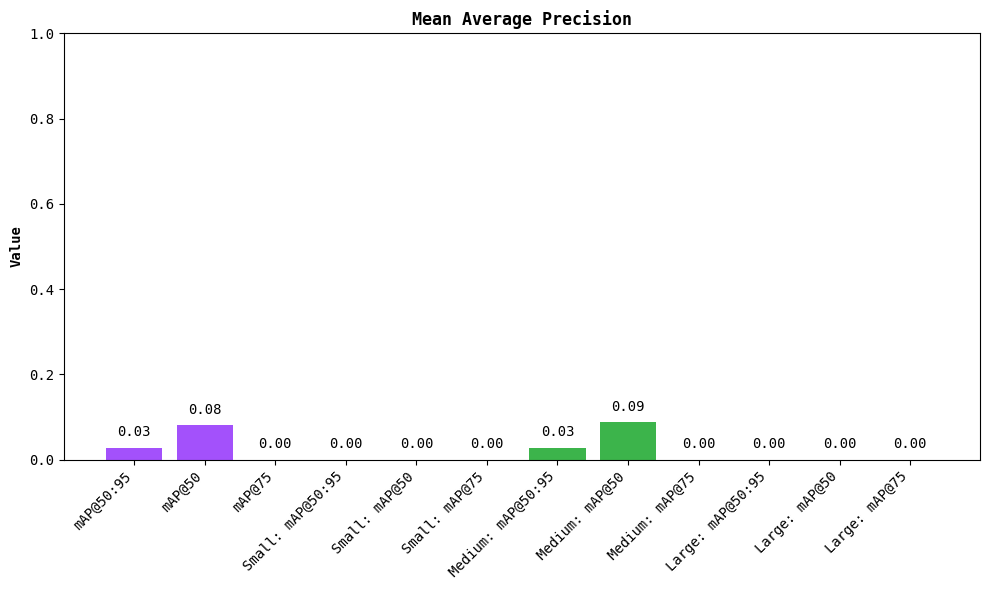

In [14]:
map_result.plot()

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances
0,0.1,0.296296,0.258065,0.275862,8.0,19.0,23.0,31.0
0,0.3,0.148148,0.129032,0.137931,4.0,23.0,27.0,31.0
0,0.5,0.148148,0.129032,0.137931,4.0,23.0,27.0,31.0
0,0.7,0.000000,0.000000,0.000000,0.0,27.0,31.0,31.0




Plot of Confusion matrix at IoU 0.7


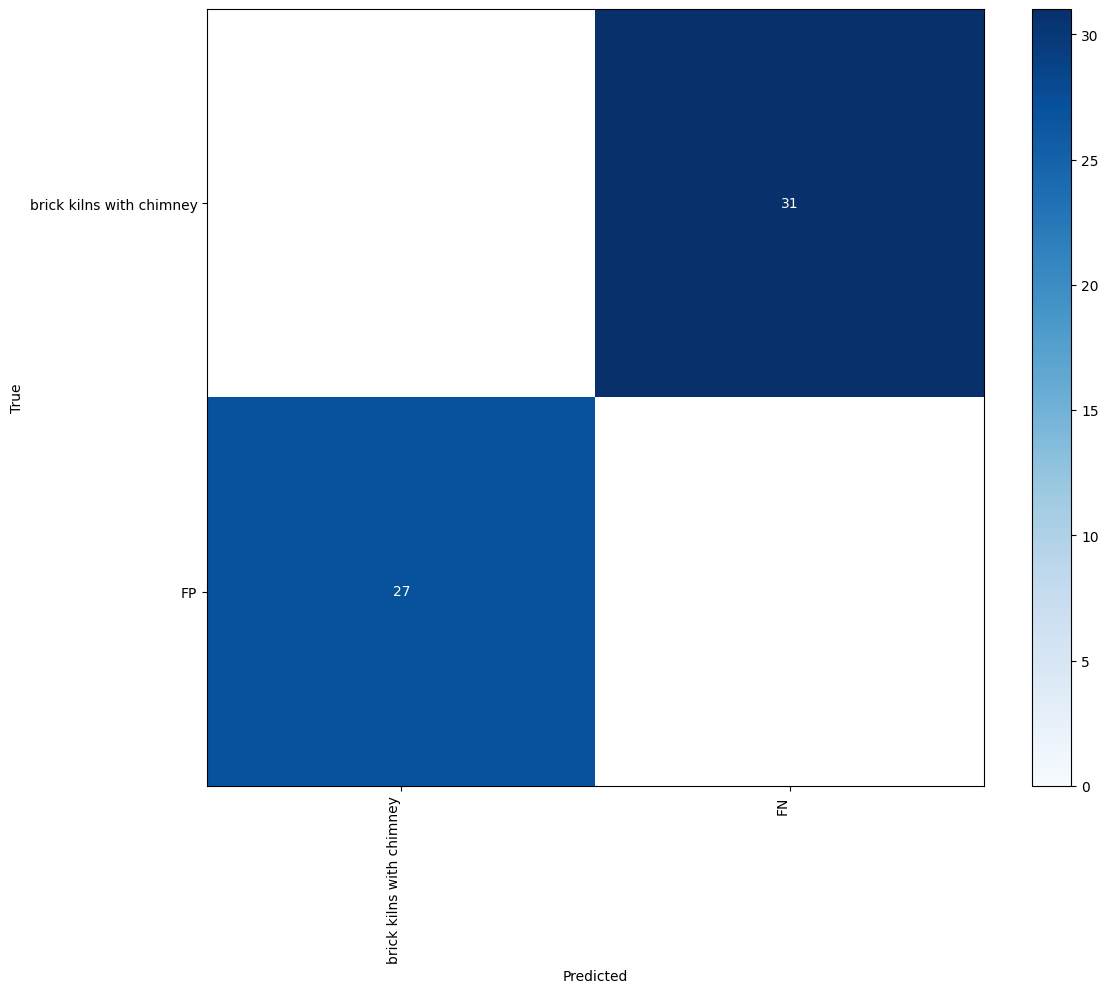

In [15]:
# @title Calculate Confusion Matrix
# what is the IoU threshold while computing confusion matrix default confidence threshold = 0.3
import pandas as pd
df = pd.DataFrame({}, columns = ['IoU', 'Precision', 'Recall', 'F1 score', 'TP', 'FP', 'FN', 'Kiln instances'])
for iou in [0.1,0.3,0.5,0.7]:
    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,
        conf_threshold = 0.25, # paligemma2 does not give confidence score so no use of conf_threshold  
        iou_threshold=iou
    )

    # calculate precision recall and f1-score
    cm = confusion_matrix.matrix
    tp = cm.diagonal().sum() - cm[-1][-1]
    predicted_positives = cm[:,:-1].sum()
    actual_positives = cm[:-1, :].sum()
    precision = tp/ (predicted_positives + 1e-9)
    recall = tp/ (actual_positives + 1e-9)
    f1_score = 2*precision*recall / (precision + recall + 1e-9)
    false_positives = predicted_positives - tp

    df = pd.concat([df, pd.DataFrame({'IoU': iou, 'Precision': precision, 'Recall': recall, 'F1 score': f1_score, 'TP': tp, 'FP': false_positives, 'FN': actual_positives - tp, 'Kiln instances': actual_positives}, index = [0])])
display(df)

print(f'\n\nPlot of Confusion matrix at IoU {iou}')
_ = confusion_matrix.plot()

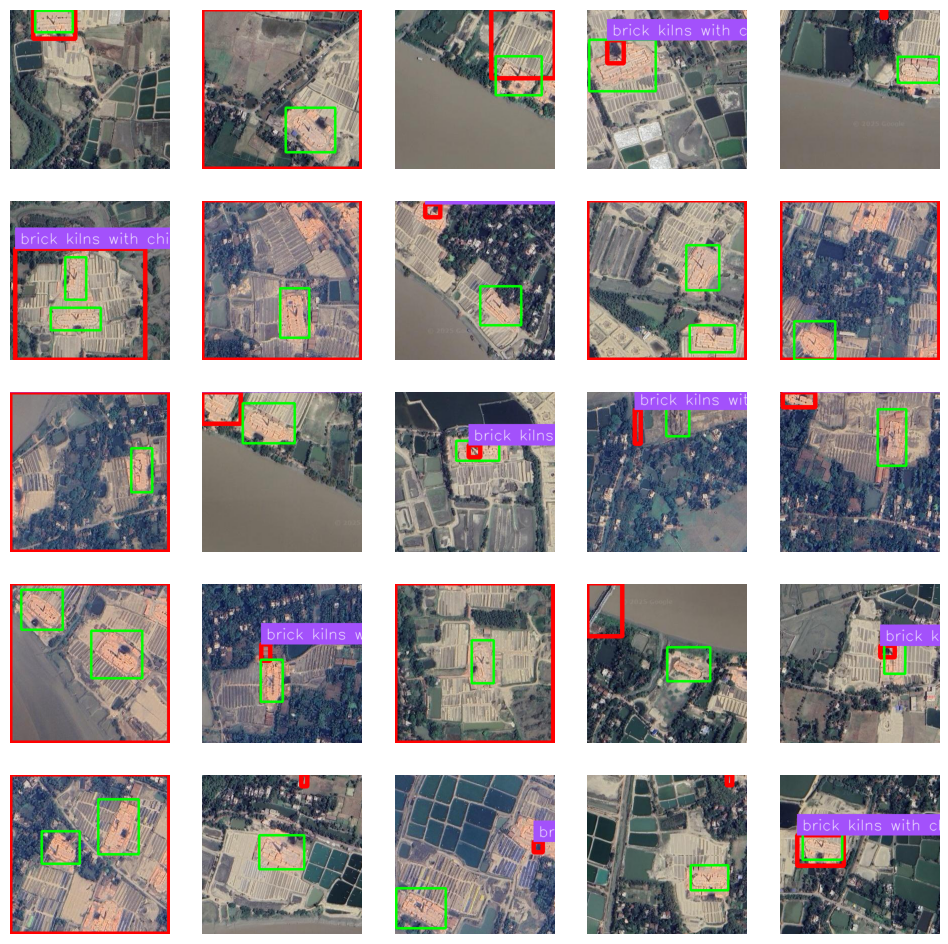

In [16]:
annotated_images = []

for i in range(0,25):
    image = images[i]
    detections = predictions[i]
    target = targets[i]
    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator(thickness=8, color=sv.Color(r=255, g=0, b=0)).annotate(annotated_image, detections)
    annotated_image = sv.BoxAnnotator(thickness=4, color=sv.Color(r=0, g=255, b=0)).annotate(annotated_image, target)
    annotated_image = sv.LabelAnnotator(text_scale=1, text_thickness=1, smart_position=True).annotate(annotated_image, detections)
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, (5,5))

In [38]:
# sum = 0
# for pred in predictions:
#     for classname in pred.data['class_name']:
#         if 'background' == classname:
#             sum += 1

# print(sum)

In [39]:
# sum = 0
# for pred in predictions:
#     for classname in pred.data['class_name']:
#         if 'brick kilns with chimney' == classname:
#             sum += 1

# print(sum)

In [40]:
# sum = 0
# for target in targets:
#     for classname in target.data['class_name']:
#         if 'brick kilns with chimney' == classname:
#             sum += 1
#             # print(pred.data['class_name'])
# print(sum)

In [41]:
# sum = 0
# for target in targets:
#     for classname in target.data['class_name']:
#         if 'background' == classname:
#             sum += 1
#             # print(pred.data['class_name'])
# print(sum)

In [42]:
# from ultralytics import YOLO
# name="lucknow"
# task="obb"
# suffix=f'v_{num_non_bg_image}_{2*num_non_bg_image}'
# base_path= '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yolo'
# data='/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yolo/data.yml'
# imgsz = 320
# epochs = 100
# experiment_name = f'{name}_{task}_{suffix}_{imgsz}_{epochs}'

# model = YOLO("yolo11m-obb.yaml")
# results = model.train(data=data, 
#                       epochs=epochs, 
#                       imgsz=imgsz, 
#                       task= task, 
#                       batch = 4, 
#                       device = id, 
#                       name = f'{base_path}/runs/{experiment_name}',
#                       val = False,
#                       save_conf = True,
#                       save_txt = True,
#                       save = True)